# Refinement of PbSO4 with least-squares
In this example we will refine the neutron data for PbSO4 using least-squares fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# esyScience, diffraction
from easyDiffractionLib import Phases
from easyDiffractionLib.sample import Sample as Job
from easyDiffractionLib.interface import InterfaceFactory as Calculator
from easyDiffractionLib.elements.Experiments.Pattern import Pattern1D
from easyDiffractionLib.elements.Backgrounds.Point import PointBackground, BackgroundPoint
from easyDiffractionLib.Profiles.P1D import Instrument1DCWParameters as CWParams

from easyCore.Fitting.Fitting import Fitter

GSAS-II binary directory: /home/erik/.local/lib/python3.8/site-packages/GSASII/bindist
ImportError for wx/mpl in GSASIIctrlGUI: ignore if docs build


In [2]:
# helper functions

def print_parameters(job):
    """ Print all fit-parameters in job. """
    for x in job.get_fit_parameters():
        print(x)
    

def compute_rmse(y_target, y_predicted):
    """ Compute root mean squared error (RMSE) between target and predicted values """
    delta_y = y_target - y_predicted
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse

def compute_mse_weighted(y_target, y_predicted):
    """ Compute the weighted mean squared error. (weighting by y_target) """
    delta_y = y_target - y_predicted
    weight = y_target
    mse_weighted = np.mean(delta_y**2 / weight)
    return mse_weighted

## Load the data and setup Job

In [3]:
# load cif
cif_fname = '../datasets/neutron_powder_PbSO4/PbSO4.cif'
phases = Phases.from_cif_file(cif_fname)

# load diffraction data
meas_fname = '../datasets/neutron_powder_PbSO4/D1A@ILL.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print('Data shape:', meas_x.shape, meas_y.shape)

# setup interface to CrysPy and Job
calculator = Calculator(interface_name='CrysPy')
job = Job(phases=phases, parameters=CWParams(), interface=calculator)

Data shape: (2201,) (2201,)
Temp CIF: /tmp/easydiffraction_temp.cif


## Define which parameters to refine
Here the parameters to be refined are determined, and initial values are set rather close to the optimal solution in order for bumps-dream to converge quicker.

In [4]:
# setup 
job.parameters.wavelength = 1.912

# add background
bkg = PointBackground(linked_experiment='PbSO4')
bkg.append(BackgroundPoint.from_pars(meas_x[0], 200))
bkg.append(BackgroundPoint.from_pars(meas_x[-1], 250))
job.set_background(bkg)

# set which parameters to refine
job.pattern.scale.fixed = True
job.phases[0].scale.fixed = False
job.pattern.zero_shift.fixed = False
job.parameters.resolution_u.fixed = False
job.parameters.resolution_v.fixed = False
job.parameters.resolution_w.fixed = False
job.backgrounds[0][0].y.fixed = False
job.backgrounds[0][1].y.fixed = False

job.phases[0].cell.length_a.fixed = False
job.phases[0].cell.length_b.fixed = False
job.phases[0].cell.length_c.fixed = False

print('Initial parameters:')
print_parameters(job)

Initial parameters:
<Parameter 'length_a': 8.48+/-0 Å, bounds=[0:inf]>
<Parameter 'length_b': 5.398+/-0 Å, bounds=[0:inf]>
<Parameter 'length_c': 6.958+/-0 Å, bounds=[0:inf]>
<Parameter 'scale': 1.0+/-0, bounds=[0:inf]>
<Parameter 'resolution_u': 0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.0002+/-0, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.012+/-0, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.0+/-0, bounds=[-inf:inf]>
<Parameter 'intensity': 200.0+/-0, bounds=[-inf:inf]>
<Parameter 'intensity': 250.0+/-0, bounds=[-inf:inf]>


## Diffraction pattern before fitting

Initial: RMSE 417.279, MSE-weighted 171.943


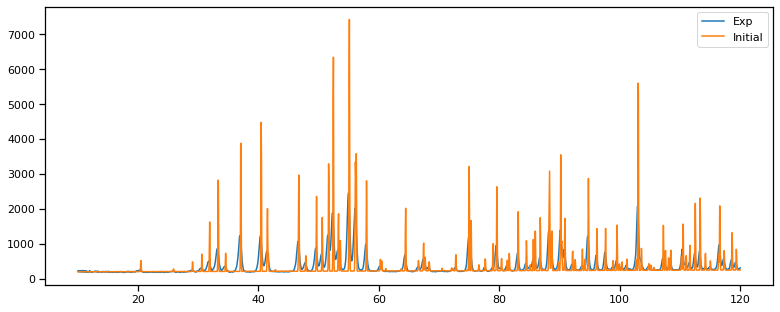

In [5]:
# Initial before fit
y_initial = calculator.fit_func(meas_x)
rmse_initial = compute_rmse(meas_y, y_initial)
msew_initial = compute_mse_weighted(meas_y, y_initial)
print(f'Initial: RMSE {rmse_initial:.3f}, MSE-weighted {msew_initial:.3f}')

# plot
fig = plt.figure(figsize=(11, 4.5))

plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.legend()
fig.tight_layout()

## Fitting with least-squares
The least-squares fitting is done through `lmfit` package, which is the default fitting engine.

In [6]:
fitter = Fitter(job, calculator.fit_func)
print('Fitting engine:', fitter.engine.name)

weights = 1/np.sqrt(meas_y)
result = fitter.fit(meas_x, meas_y, weights=weights, method='least_squares', minimizer_kwargs={'diff_step': 1e-8})

Fitting engine: lmfit


In [11]:
# print refined parameters
print_parameters(job)
y_refined = calculator.fit_func(meas_x)
rmse_refined = compute_rmse(meas_y, y_refined)
msew_refined = compute_mse_weighted(meas_y, y_refined)
print(f'Refined: RMSE {rmse_refined:.3f}, MSE-weighted {msew_refined:.3f}')

# save data
data = dict()
for p in job.get_fit_parameters():
    key = p.name
    if key in data:
        key = key + '-1'
    data[key] = p.raw_value, p.error
np.save('refinement_results/least_squares.npy', data, allow_pickle=True)

<Parameter 'length_a': 8.47701+/-0.00027 Å, bounds=[0:inf]>
<Parameter 'length_b': 5.39576+/-0.00019 Å, bounds=[0:inf]>
<Parameter 'length_c': 6.95584+/-0.00032 Å, bounds=[0:inf]>
<Parameter 'scale': 1.211+/-0.006, bounds=[0:inf]>
<Parameter 'resolution_u': 0.195+/-0.016, bounds=[-inf:inf]>
<Parameter 'resolution_v': -0.476+/-0.030, bounds=[-inf:inf]>
<Parameter 'resolution_w': 0.479+/-0.013, bounds=[-inf:inf]>
<Parameter 'zero_shift': 0.1568+/-0.0028, bounds=[-inf:inf]>
<Parameter 'intensity': 197.1+/-1.2, bounds=[-inf:inf]>
<Parameter 'intensity': 240.1+/-1.6, bounds=[-inf:inf]>
Refined: RMSE 44.076, MSE-weighted 3.420


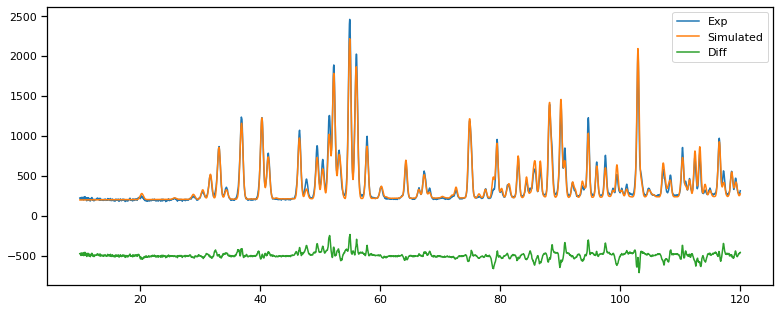

In [8]:
# plot refined diffraction pattern
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_refined, label='Simulated')
plt.plot(meas_x, meas_y - y_refined-500, label='Diff')
plt.legend()
fig.tight_layout()